# Autocorrelogram Periodogram
## Analytic Cycle chapter 9

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [2]:
# Import some useful libraries and tools
import pandas as pd
import numpy as np

from numpy import pi

import elhers_indicators as ei

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('ticks')

In [3]:
idx = np.arange(1000)
wavelenght = np.zeros(len(idx))
wavelenght[:250] = 38
wavelenght[250:500] = 24
wavelenght[500:750] = 12
wavelenght[750:] = 16
na_price = np.sin(2*np.pi*idx/wavelenght)
obs = na_price.shape[0]

In [4]:
short_period = 10
long_period = 40
window = long_period - short_period + 1

window_length = 3

na_corr = np.zeros(long_period)
sq_sum = np.zeros((obs, window))  # Just for debug!
R = np.ones((window, 2)) 
pwr = np.zeros((obs, window))
dominant_cycle = np.zeros(obs)

max_pow = 1

HP = ei.high_pass_filter(na_price, long_period, False)
Filt = ei.super_smoother(HP, short_period)
Filt = na_price

for n in range(long_period + window_length + 2, obs):   # 2 for the correlation and 2 for the indicator lag
    for lag in range(1, long_period+1):
#        window_length = min(max(window_length, lag), long_period/2) if (n-long_period-window_length > 0) else window_length
        current_series = Filt[n-window_length:n]
        lagged_series =  Filt[n-window_length-lag:n-lag]
        na_corr[lag-1] = np.corrcoef(current_series, lagged_series)[0,1]
    
    # DFT in Python list comprehension fashion
    cosine_part = np.array([na_corr[N] * np.cos(2 * pi * (N + 1) / (per))
                            for N in range(long_period)
                            for per in range(short_period, long_period+1)]) # Elhers uses 3 as init
    sine_part = np.array([na_corr[N] * np.sin(2 * pi * (N + 1) / (per))
                          for N in range(long_period)
                          for per in range(short_period, long_period+1)])

    cosine_part = cosine_part.reshape((long_period, window)).sum(axis=0)
    sine_part = sine_part.reshape((long_period, window)).sum(axis=0)
    
    sq_sum[n, :] = (cosine_part**2 + sine_part**2)**0.5
    R[:,0] = R[:,1]
    R[:,1] = 0.8 * sq_sum[n, :] ** 2 + 0.2 * R[:,0]
    max_pow *= 0.995
    max_pow = max(np.amax(R[:,1]), max_pow)
    pwr[n, :] = (R[:,1] / max_pow)**2

    spx = np.dot(pwr[n, :], np.arange(short_period, long_period + 1))
    sp = pwr[n, :].sum()
    dominant_cycle[n] = spx / sp

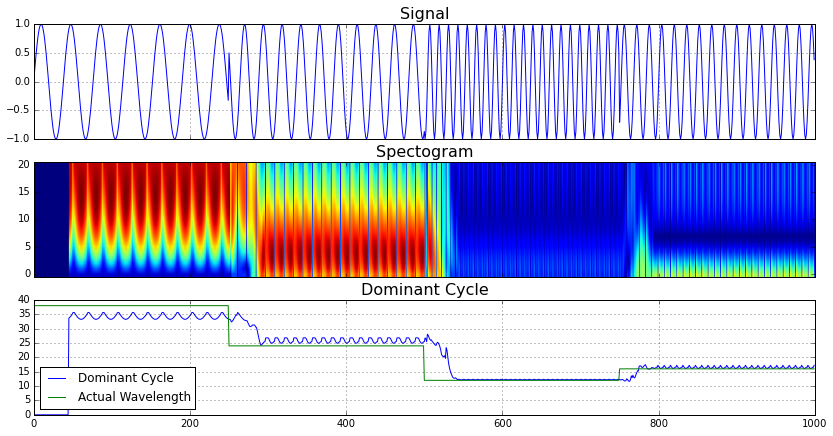

In [7]:
fig, axs = plt.subplots(3, 1, sharex=True)
    
axs[0].set_title('Signal', fontsize=16)
axs[0].plot(idx, na_price)
axs[0].grid()
axs[0].set_xlim(xmin=0)

axs[1].set_title('Spectogram', fontsize=16)
axs[1].imshow(sq_sum[:, short_period:].T, aspect='auto')
axs[1].invert_yaxis()

axs[2].set_title('Dominant Cycle', fontsize=16)
axs[2].plot(idx, dominant_cycle, label= 'Dominant Cycle')
axs[2].plot(idx, wavelenght, label='Actual Wavelength')
axs[2].legend(loc='lower left')
axs[2].grid()
plt.show()